# Sentiment Analysis using Q-NLP
* Naveen Nidadavolu 22MIA1049  
* Shivam Thakur 22BPS1014  
* Ram Sasidhar Putcha 22MIA1055  
* Yasir Ahmad 22MIA1064  

**Citations**  
> Emirhan BULUT. (2022). Emotion Prediction with Quantum5 Neural Network AI [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DS/2129637

**Our Changes**
1. Text Preprocessing
2. Model Architecture

### For backwards compatibiliy
> qml.qnn.KerasLayer  

KerasLayer requires a Keras version lower than 3. For instructions on running with Keras 2
But, tensorflow automatically installs Keras 3

Install tf_keras: `pip install tf_keras`  
Change env variables to use legacy keras

In [3]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

## Required Libraries

The libraries required for for implementation
```
!pip install pip install tensorflow==2.7.0
!pip install tensorflow-quantum==0.7.2
!pip install pennylane
!pip install tf_keras
!pip uninstall keras
!pip install keras==2.9.0
!pip install cirq==0.13.1
```

# Import Libraries
Importing essential libraries for the project

In [5]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

import pennylane as qml
from pennylane import numpy as p_np

from pennylane.templates.state_preparations import MottonenStatePreparation
from pennylane.templates.layers import StronglyEntanglingLayers
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Import the dataset
Import the dataset and prepare the dataframe

In [6]:
# load our data
data = pd.read_csv("P:\\QuantumML\\QML_project\\archive\\tweet_emotions.csv")
#plt.style.use('fivethirtyeight')

## EDA
Exploratory data analysis of the dataset

In [8]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


Shape of the dataset

In [152]:
data.shape

(40000, 3)

Columns

In [11]:
data.columns

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

In [9]:
data.describe()

,tweet_id
count,4.000000e+04
mean,1.845184e+09
std,1.188579e+08
min,1.693956e+09
25%,1.751431e+09
50%,1.855443e+09
75%,1.962781e+09
max,1.966441e+09


In [12]:
data.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

No null values

# Data Visualization

<Axes: xlabel='count', ylabel='sentiment'>

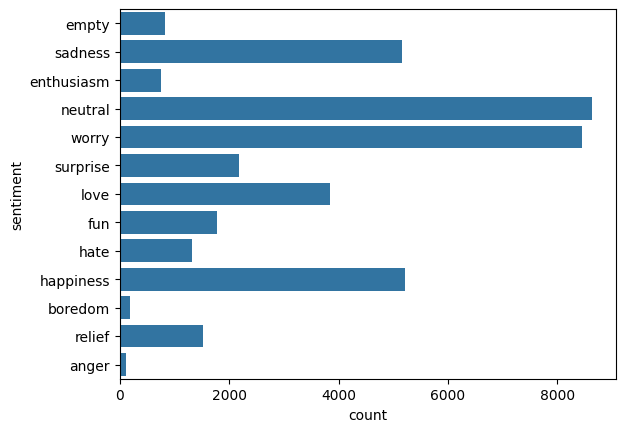

In [153]:
sns.countplot(y=data["sentiment"])

# Data Cleanup and Prepare

The original paper proposed using `RegexpStemmer` and remove expressions using  
```snowball = RegexpStemmer('ing$|s$|e$|able$', min=4)```

We propose a `PorterStemmer` and  `WordNetLemmatizer` based approach. 
    
 `PorterStemmer` removes the suffix of the word and creates stem word.  
  `WordNetLemmatizer` leverages WordNet, a lexical database for the English Language to reduce words to base or dictionary forms.

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YasirAhmd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YasirAhmd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YasirAhmd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

# Initialize stop words, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Process the content
data["content"] = data["content"].apply(lambda x: " ".join([
    lemmatizer.lemmatize(porter_stemmer.stem(re.sub(r'[^\w\d]', "", word)))
    for word in x.lower().split() if word not in stop_words
]))

# Tokenize and pad sequences
X = data["content"]
tokenize = Tokenizer()
tokenize.fit_on_texts(X)

max_length = 64
vocab_size = len(tokenize.word_index) + 1
X = pad_sequences(tokenize.texts_to_sequences(X), maxlen=max_length, padding="post")

Stemmed and Lemmatized data

In [156]:
data

,tweet_id,sentiment,content
0,1956967341,empty,tiffanylu know listenin bad habit earlier star...
1,1956967666,sadness,layin n bed headach ughhhhwaitin call
2,1956967696,sadness,funer ceremonygloomi friday
3,1956967789,enthusiasm,want hang friend soon
4,1956968416,neutral,dannycastillo want trade someon houston ticket...
...,...,...,...
39995,1753918954,neutral,johnlloydtaylor
39996,1753919001,love,happi mother day love
39997,1753919005,love,happi mother day mommi there woman man long mo...
39998,1753919043,happiness,niariley wassup beauti follow me peep new hit ...


Tokenized and encoded data

In [157]:
X

array([[12612,    18,  2826, ...,     0,     0,     0],
       [ 7991,   226,    88, ...,     0,     0,     0],
       [ 2073, 12614,   153, ...,     0,     0,     0],
       ...,
       [   14,    26,     2, ...,     0,     0,     0],
       [ 6391,  2655,   275, ...,     0,     0,     0],
       [12593,  7500,   520, ...,     0,     0,     0]])

# Preparation of the Model  
The model architecture consists of several layers that are sequentially connected to form a neural network.   
Architecture:

**Quantum Layer (qlayer)**: This layer is implemented using the qnode function. It takes in two inputs: inputs and weights. The inputs represent the input data, and the weights represent the learnable parameters of the quantum layer.  
Inside the qnode function:  
>The `AngleEmbedding` template is used to encode the input data onto the quantum state.  
  
>The `StronglyEntanglingLayers` template is used to apply a series of parameterized quantum gates to the quantum state.  
  
>Finally, the expectation values of the `Pauli-Z` operators on qubits 0 and 1 are computed using `qml.expval`.  

The output of the quantum layer is a tuple of these two expectation values.

**Dense Layer (clayer1)**: This is a traditional dense layer implemented using the **Dense** class `from tf.keras.layers`. It takes in the output of the quantum layer as input and applies a linear transformation followed by an activation function. The number of neurons in this layer is 2.

**Dense Layer (clayer2)**: This is another dense layer similar to clayer1.

**Dense Layer (clayer3)**: This is the final dense layer of the model. It takes in the output of clayer2 as input and applies a linear transformation followed by a *softmax* activation function. The number of neurons in this layer is 13, which corresponds to the number of classes in the classification task.

The model is compiled using the stochastic gradient descent (SGD) optimizer with a learning rate of 0.8, and the mean absolute error (MAE) loss function is used for training the model.



In [16]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

weight_shapes = {"weights": (3, n_qubits, 3)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=2)
clayer1 = tf.keras.layers.Dense(2)
clayer2 = tf.keras.layers.Dense(2)
clayer3 = tf.keras.layers.Dense(13, activation="softmax")
model = tf.keras.models.Sequential([clayer1, qlayer, clayer2, clayer3])
opt = tf.keras.optimizers.SGD(learning_rate=0.8)
model.compile(opt, loss='mae')

# Preparation of Label

In [17]:
Y = data['sentiment']

In [18]:
Y.value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

In [19]:
Y

0             empty
1           sadness
2           sadness
3        enthusiasm
4           neutral
            ...    
39995       neutral
39996          love
39997          love
39998     happiness
39999          love
Name: sentiment, Length: 40000, dtype: object

In [20]:
from sklearn.preprocessing import LabelEncoder

func = LabelEncoder()
Y = func.fit_transform(Y)
Y

array([ 2, 10, 10, ...,  7,  5,  7])

In [21]:
tf.convert_to_tensor(Y)

<tf.Tensor: shape=(40000,), dtype=int32, numpy=array([ 2, 10, 10, ...,  7,  5,  7])>

In [22]:
tf.one_hot(Y, depth=1)

<tf.Tensor: shape=(40000, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [24]:
print(f"X shape = {X.shape}")
print(f"Y shape = {Y.shape}")

X shape = (40000, 64)
Y shape = (40000,)


# Model Fitting

In [25]:
model.fit(X,Y, epochs=5, batch_size=256, shuffle=True,steps_per_epoch=1,validation_split=0.2)

Epoch 1/5

1/1 [==============================] - 6s 6s/step - loss: 8.1028 - val_loss: 7.2357
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 8.4465 - val_loss: 7.2357
Epoch 3/5
1/1 [==============================] - 7s 7s/step - loss: 8.2440 - val_loss: 7.2357
Epoch 4/5
1/1 [==============================] - 5s 5s/step - loss: 8.0649 - val_loss: 7.2357
Epoch 5/5
1/1 [==============================] - 6s 6s/step - loss: 8.3098 - val_loss: 7.2357


# Preparation of Prediction Data and Prediction Equation

In [73]:
a = "The loved the movie, the story was amazing and the acting was great."
tokenize.fit_on_texts(a)

max_length = 64
vocab_size = len(tokenize.word_index) + 1
a = pad_sequences(tokenize.texts_to_sequences(a), maxlen=max_length, padding="post")

In [74]:
a = tf.constant(a)
prediction = model.predict(a)

3/3 [==============================] - 0s 64ms/step


In [75]:
ap = []
for i in range(len(prediction)):
    ap.append(np.argmax(prediction[i]))
np.argmax(ap)

3

In [76]:
result = np.argmax(ap)
result = np.array(result).reshape(1)

In [77]:
func.inverse_transform(result)

array(['enthusiasm'], dtype=object)

In [78]:
result

array([3], dtype=int64)

In [85]:
a = input("Enter your statement: ")
print(a)

tokenize.fit_on_texts(a)
max_length = 64
vocab_size = len(tokenize.word_index) + 1
a = pad_sequences(tokenize.texts_to_sequences(a), maxlen=max_length, padding="post")
a = tf.constant(a)

output = []

for i in range(10):
    try:

        prediction = model.predict(a)
        ap = []
        for i in range(len(prediction)):
            ap.append(np.argmax(prediction[i]))
        np.argmax(ap)
        result = np.argmax(ap)
        result = np.array(result).reshape(1)
        output.append(func.inverse_transform(result))
    except:
        print("Invalid input")
    

output

this is amazing
1/1 [==============================] - 0s 143ms/step


[array(['fun'], dtype=object),
 array(['fun'], dtype=object),
 array(['fun'], dtype=object),
 array(['fun'], dtype=object),
 array(['fun'], dtype=object),
 array(['fun'], dtype=object),
 array(['fun'], dtype=object),
 array(['fun'], dtype=object),
 array(['fun'], dtype=object),
 array(['fun'], dtype=object)]